In [ ]:
import os
import torch
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
from utils.vae import VAE

Epoch [1/300], Batch [1/1], Loss: 6488038.0000
Epoch [1/300], Mean Loss: 6488038.0000
Epoch [2/300], Batch [1/1], Loss: 1679705216.0000
Epoch [2/300], Mean Loss: 1679705216.0000
Epoch [3/300], Batch [1/1], Loss: 45052276.0000
Epoch [3/300], Mean Loss: 45052276.0000
Epoch [4/300], Batch [1/1], Loss: 404630304.0000
Epoch [4/300], Mean Loss: 404630304.0000
Epoch [5/300], Batch [1/1], Loss: 5251029.5000
Epoch [5/300], Mean Loss: 5251029.5000
Epoch [6/300], Batch [1/1], Loss: 4090280.5000
Epoch [6/300], Mean Loss: 4090280.5000
Epoch [7/300], Batch [1/1], Loss: 3074904.0000
Epoch [7/300], Mean Loss: 3074904.0000
Epoch [8/300], Batch [1/1], Loss: 2890897.5000
Epoch [8/300], Mean Loss: 2890897.5000
Epoch [9/300], Batch [1/1], Loss: 3152640.5000
Epoch [9/300], Mean Loss: 3152640.5000
Epoch [10/300], Batch [1/1], Loss: 2910048.7500
Epoch [10/300], Mean Loss: 2910048.7500
Epoch [11/300], Batch [1/1], Loss: 2615991.0000
Epoch [11/300], Mean Loss: 2615991.0000
Epoch [12/300], Batch [1/1], Loss: 236

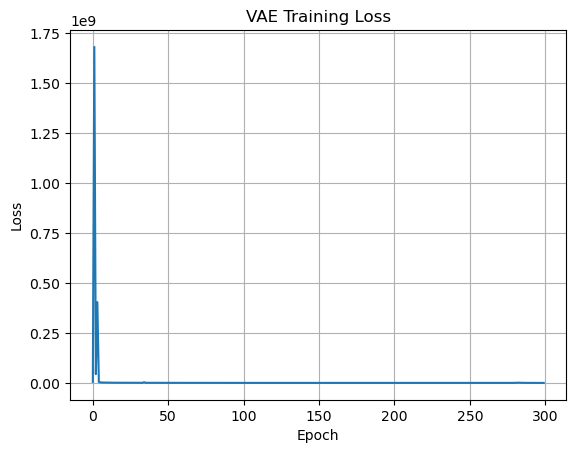

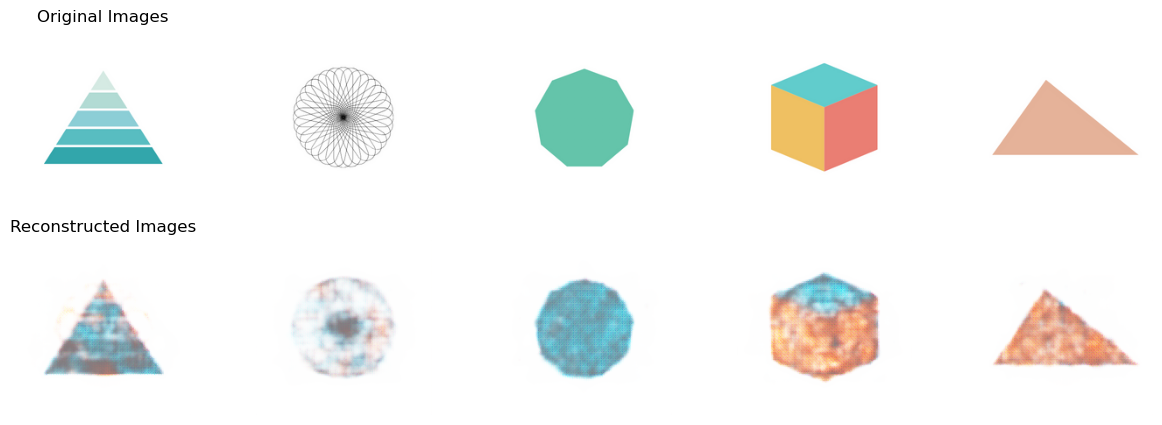

In [ ]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image
from torchvision import transforms

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data transformation (resize and convert to tensor)
transform = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor()
])

class ShapeImageDataset(Dataset):
    def __init__(self, df_path, image_dir, transform=None):

        self.df = pd.read_csv(df_path) 
        self.image_dir = image_dir  
        self.transform = transform  
        self.emotion_columns = self.df.columns[7:]  

    def __len__(self):
        return min(len(self.df), len(os.listdir(self.image_dir)))

    def __getitem__(self, idx):

        adjusted_idx = idx + 1

        if adjusted_idx > len(self.df) or adjusted_idx > len(os.listdir(self.image_dir)):
            raise IndexError("Index out of range for dataset.")


        row = self.df.iloc[adjusted_idx - 1]
        image_path = os.path.join(self.image_dir, f"{adjusted_idx}.png")

        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")
            image = Image.new("RGB", (200, 200), (255, 255, 255))

        if self.transform:
            image = self.transform(image)

        labels = row[self.emotion_columns].fillna(0).values.astype(np.float32)
        label_tensor = torch.tensor(labels, dtype=torch.float32)

        return image, label_tensor

path = "data/shapes.csv"   
image_dir = "data/images"  

dataset = ShapeImageDataset(df_path=path, image_dir=image_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=80, shuffle=True)

class VAE(nn.Module):
    def __init__(self, latent_dim=28, image_size=(200, 200)):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        self.image_size = image_size

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=4, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1)
        
        self.flattened_size = self.calculateFlattenedSize(image_size)
        
        self.fc1 = nn.Linear(self.flattened_size, 512)
        self.fc21 = nn.Linear(512, self.latent_dim)
        self.fc22 = nn.Linear(512, self.latent_dim)

        self.fc3 = nn.Linear(self.latent_dim, 512)
        self.fc4 = nn.Linear(512, self.flattened_size)
        
        self.deconv1 = nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1)
        self.deconv2 = nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1)

        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)

    def calculateFlattenedSize(self, shape):
        x = torch.zeros(1, 3, *shape)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        return int(torch.prod(torch.tensor(x.size())))

    def encoder(self, x, sentiment_vector):
        x = nn.functional.relu(self.bn1(self.conv1(x)))
        x = nn.functional.relu(self.bn2(self.conv2(x)))
        x = nn.functional.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)
        h1 = nn.functional.relu(self.fc1(x))
        mu = self.fc21(h1) + sentiment_vector 
        logvar = self.fc22(h1)
        return mu, logvar

    def decoder(self, z):
        h3 = nn.functional.relu(self.fc3(z))
        h4 = nn.functional.relu(self.fc4(h3))
        batch_size = z.size(0)
        h4 = h4.view(batch_size, 128, 25, 25)

        x = nn.functional.relu(self.deconv1(h4))
        x = nn.functional.relu(self.deconv2(x))
        x = torch.sigmoid(self.deconv3(x))  
        return x

    def forward(self, x, sentiment_vector):
        mu, logvar = self.encoder(x, sentiment_vector)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decoder(z)
        return recon_x, mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

def plotLoss(recon_x, x, mu, logvar):
    BCE = torch.nn.functional.binary_cross_entropy(recon_x.view(-1, 200*200*3), x.view(-1, 200*200*3), reduction='sum')
    KL = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KL

losses = []
def trainVae(model, dataloader, optimizer, n_epochs=300):
    model.train()  
    for epoch in range(n_epochs):
        epoch_loss = 0.0
        for idx, (data, sentiment_vector) in enumerate(dataloader):
            data = data.to(device)
            sentiment_vector = sentiment_vector.to(device)
            
            optimizer.zero_grad()

            output, mean, logvar = model(data, sentiment_vector)

            loss = plotLoss(output, data, mean, logvar)
            loss.backward()

            optimizer.step()

            epoch_loss += loss.item()

            if idx % 100 == 0:
                print(f"Epoch [{epoch+1}/{n_epochs}], Batch [{idx+1}/{len(dataloader)}], Loss: {loss.item():.4f}")

        mean_loss = epoch_loss / len(dataloader)
        losses.append(mean_loss)

        print(f"Epoch [{epoch+1}/{n_epochs}], Mean Loss: {mean_loss:.4f}")

    plotLossCurve(losses)

def visualizeSample(model, dataloader, n_samples=30):
    model.eval()  
    loader = iter(dataloader)
    
    images, sentiment_vectors = next(loader)  

    images = images.to(device)
    sentiment_vectors = sentiment_vectors.to(device)

    with torch.no_grad():
        output_images, _, _ = model(images, sentiment_vectors)

    images = images.cpu().numpy()
    output_images = output_images.cpu().numpy()

    fig, subplots = plt.subplots(nrows=2, ncols=n_samples, figsize=(15, 5))

    for i in range(n_samples):
        subplots[0, i].imshow(images[i].transpose(1, 2, 0))  
        subplots[0, i].axis('off')

        subplots[1, i].imshow(output_images[i].transpose(1, 2, 0))  
        subplots[1, i].axis('off')

        subplots[0, 0].set_title('Original Images')
        subplots[1, 0].set_title('Reconstructed Images')

    plt.show()

def plotLossCurve(losses):
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('VAE Training Loss')
    plt.grid(True)
    plt.show()

model = VAE(latent_dim=28).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

trainVae(model, dataloader, optimizer, n_epochs=300)

visualizeSample(model, dataloader)


In [10]:
# Save the model's state_dict
torch.save(model.state_dict(), "vae_model.pth")

print("Model saved as 'vae_model.pth'")


Model saved as 'vae_model.pth'


In [1]:
model = 'vae_model.pth'
model = VAE(latent_dim=28).to(device)
model.load_state_dict(torch.load(model, map_location=device))
model.eval()


def visualizeSample(model, dataloader, n_samples=30):
    model.eval()  
    loader = iter(dataloader)
    
    images, sentiment_vectors = next(loader)  

    images = images.to(device)
    sentiment_vectors = sentiment_vectors.to(device)

    with torch.no_grad():
        output_images, _, _ = model(images, sentiment_vectors)

    images = images.cpu().numpy()
    output_images = output_images.cpu().numpy()

    fig, subplots = plt.subplots(nrows=2, ncols=n_samples, figsize=(15, 5))

    for i in range(n_samples):
        subplots[0, i].imshow(images[i].transpose(1, 2, 0))  
        subplots[0, i].axis('off')

        subplots[1, i].imshow(output_images[i].transpose(1, 2, 0))  
        subplots[1, i].axis('off')

    subplots[0, 0].set_title('Original Images')
    subplots[1, 0].set_title('Reconstructed Images')

    plt.show()

    visualizeSample(model, dataloader)

NameError: name 'VAE' is not defined

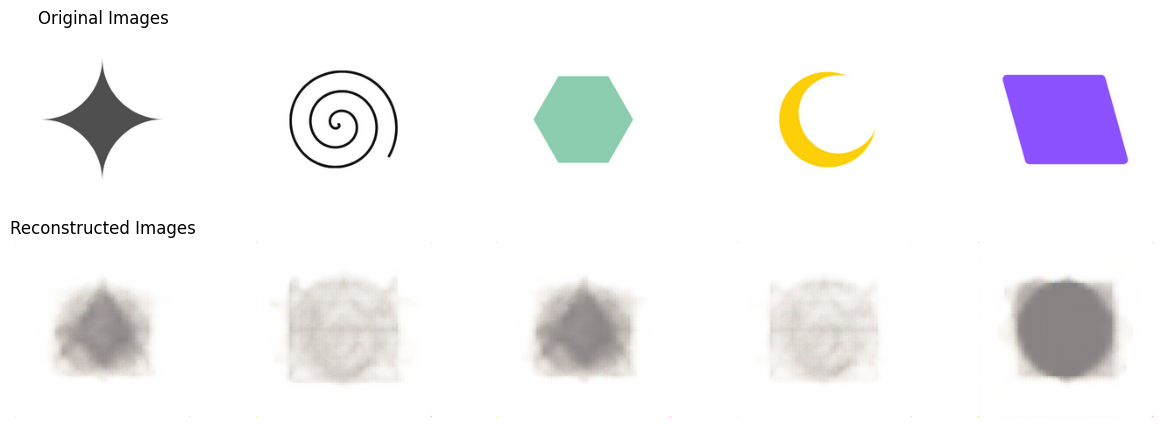

In [21]:
def visualizeSample(model, n_samples=5):
    model.eval()  
    loader = iter(dataloader)
    images = next(loader)  

    with torch.no_grad():
        output_images, _, _ = model(images.to(device))

    images = images.cpu().numpy()
    output_images = output_images.cpu().numpy()

    fig, subplots = plt.subplots(nrows=2, ncols=n_samples, figsize=(15, 5))

    for i in range(n_samples):
        subplots[0, i].imshow(images[i].transpose(1, 2, 0))
        subplots[0, i].axis('off')
        subplots[1, i].imshow(output_images[i].transpose(1, 2, 0))
        subplots[1, i].axis('off')

    subplots[0, 0].set_title('Original Images')
    subplots[1, 0].set_title('Reconstructed Images')
    plt.show()

visualizeSample(model)